In [16]:
import mlflow.xgboost
import mlflow
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, make_scorer
import mlflow.sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from mlflow import lightgbm
import seaborn as sns
import matplotlib.pyplot as plt


In [27]:

final_features_regression = [

    # numeric
    "AMT_INCOME_TOTAL",
    "DAYS_BIRTH",
    "DAYS_REGISTRATION",
    "CNT_FAM_MEMBERS",
    "REGION_RATING_CLIENT",
    "REGION_POPULATION_RELATIVE",

    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",

    "Annuity_to_Income_Ratio",

    # POS (light usage signals)
    "pos_mean_cnt_instalment",

    # Previous applications
    "avg_prev_amt_credit",
    "prev_num_approved",

    # Credit card
    "avg_cc_max_limit_used",

    # categorical
    "NAME_CONTRACT_TYPE",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "OCCUPATION_TYPE",
    "ORGANIZATION_TYPE",

    #Target
    "AMT_CREDIT"
]

In [30]:

df = pd.read_csv("../data/final/Regression_table.csv")
df=df[final_features_regression]


In [31]:
df.shape

(307511, 22)

In [32]:
df.sample(5)

,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_REGISTRATION,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_POPULATION_RELATIVE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Annuity_to_Income_Ratio,...,prev_num_approved,avg_cc_max_limit_used,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,AMT_CREDIT
234873,117000.0,39.227397,14.482192,5.0,2,0.004960,0.636586,0.118429,0.535276,0.289038,...,2.0,180000.0,Cash loans,Working,Secondary / secondary special,Married,House / apartment,Sales staff,Trade: type 7,340587.0
26196,112500.0,59.717808,15.726027,2.0,2,0.035792,0.505998,0.250811,0.345785,0.169320,...,2.0,270000.0,Cash loans,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,Unknown,XNA,647046.0
196248,162000.0,36.210959,5.731507,4.0,2,0.019101,0.379176,0.708221,0.761026,0.152778,...,4.0,180000.0,Revolving loans,Working,Secondary / secondary special,Married,House / apartment,Laborers,Postal,495000.0
185079,67500.0,41.172603,7.824658,3.0,2,0.015221,0.505998,0.359963,0.135106,0.220200,...,7.0,180000.0,Cash loans,Working,Secondary / secondary special,Married,House / apartment,Laborers,Industry: type 7,202500.0
52310,67500.0,42.882192,6.630137,3.0,2,0.015221,0.505998,0.353920,0.729567,0.224600,...,2.0,180000.0,Cash loans,Working,Secondary / secondary special,Married,House / apartment,Security staff,Other,418500.0


In [33]:
df['DAYS_BIRTH'] = abs(df['DAYS_BIRTH']) / 365
df['DAYS_REGISTRATION'] = abs(df['DAYS_REGISTRATION']) / 365

In [37]:
df['Annuity_to_Income_Ratio'] = df['Annuity_to_Income_Ratio'].clip(
    upper=df['Annuity_to_Income_Ratio'].quantile(0.99),
    axis=0
)

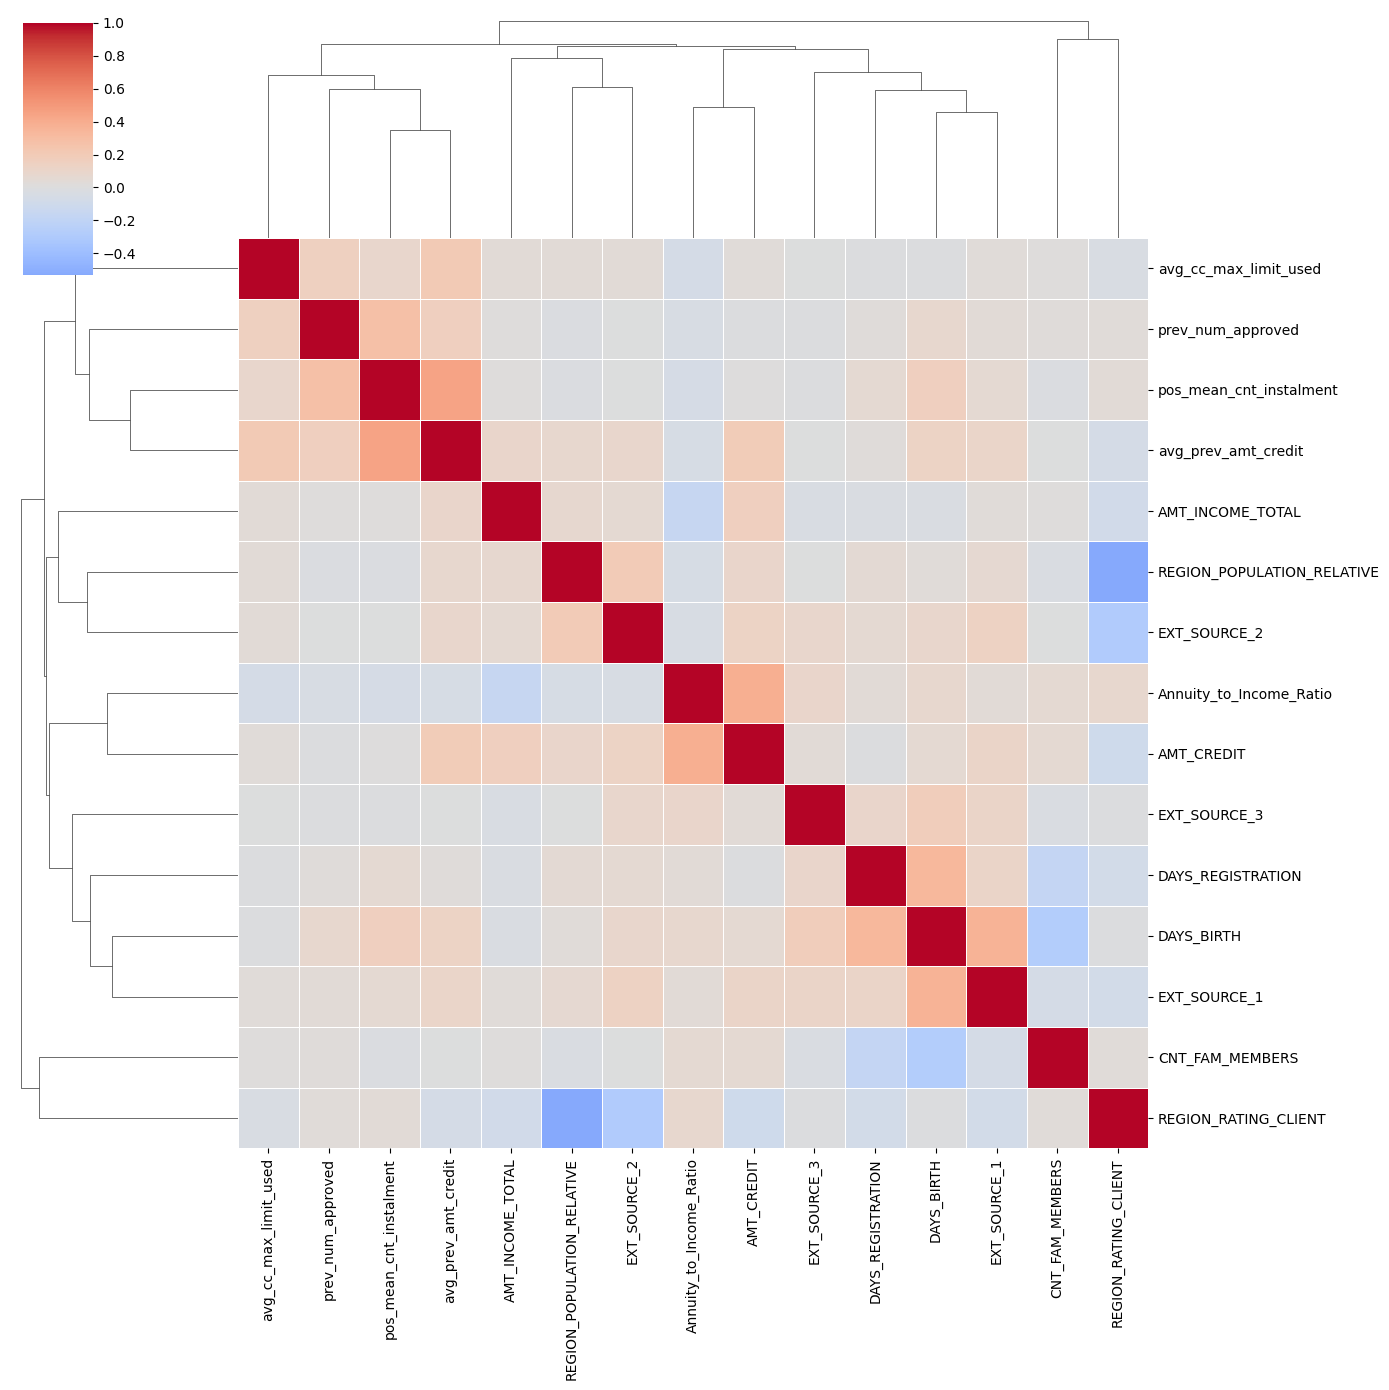

In [38]:
num_df = df[final_features_regression].select_dtypes(include=['int64', 'float64'])

corr = num_df.corr(method='pearson', min_periods=10)  
corr = corr.fillna(0)

sns.clustermap(
    corr,
    cmap='coolwarm',
    center=0,
    figsize=(14, 14),
    linewidths=0.5
)

plt.show()

Linear Regression

In [43]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [11]:
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        drop=None,
        sparse_output=False
    ))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols)
    ]
)


In [ ]:
model1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])


In [ ]:
X = df[num_cols + cat_cols]
y = df["AMT_CREDIT"] 

In [ ]:
y=np.log1p(y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [15]:
mlflow.set_experiment("loan_amount_regression")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run():
    
    model1.fit(X_train, y_train)

    preds = model1.predict(X_val)

    mae = np.mean(np.abs(np.expm1(preds) - np.expm1(y_val)))
    rmse = np.sqrt(np.mean((np.expm1(preds) - np.expm1(y_val)) ** 2))
    mlflow.log_metric("RMSE", rmse)


    mlflow.log_metric("MAE", mae)
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("features_count", X.shape[1])

    # Save model
    mlflow.sklearn.log_model(
        model1,
        artifact_path="model"
    )

    print("MAE:", mae)
    print("RMSE:", rmse)

2025/12/17 17:39:39 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/17 17:39:39 INFO mlflow.store.db.utils: Updating database tables
2025/12/17 17:39:39 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/17 17:39:39 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/17 17:39:39 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/17 17:39:39 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/17 17:39:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MAE: 204589.6949766643
RMSE: 324117.5661327247
🏃 View run charming-fawn-229 at: http://127.0.0.1:5000/#/experiments/1/runs/786fe622ca594c7b9c0763997ded7d00
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Linear Regression with PCA

In [16]:
model2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=15)),
    ("regressor", LinearRegression())
])


In [17]:
mlflow.set_experiment("loan_amount_regression")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run():
    
    model2.fit(X_train, y_train)

    preds = model2.predict(X_val)

    mae = np.mean(np.abs(np.expm1(preds) - np.expm1(y_val)))
    rmse = np.sqrt(np.mean((np.expm1(preds) - np.expm1(y_val)) ** 2))
    mlflow.log_metric("RMSE", rmse)


    mlflow.log_metric("MAE", mae)
    mlflow.log_param("model_type", "LinearRegression_PCA")
    mlflow.log_param("features_count", X.shape[1])

    # Save model
    mlflow.sklearn.log_model(
        model2,
        artifact_path="model"
    )

    print("MAE:", mae)
    print("RMSE:", rmse)


2025/12/17 17:40:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MAE: 234612.91131174675
RMSE: 344981.17693491455
🏃 View run rogue-moth-948 at: http://127.0.0.1:5000/#/experiments/1/runs/4e5be9e93e484539bae0129bb10a038e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


XGBRegressor

In [44]:
df_model = df[final_features_regression]

for col in cat_cols:
    df_model[col] = df_model[col].fillna("Unknown")
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

In [48]:
X = df_model.drop(columns=['AMT_CREDIT'])
y = df["AMT_CREDIT"] 
y=np.log1p(y)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [49]:
model3= XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.06,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1)

In [50]:
mlflow.set_experiment("loan_amount_regression")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run():
    model3.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
)

    preds = model3.predict(X_val)

    mae = np.mean(np.abs(np.expm1(preds) - np.expm1(y_val)))
    rmse = np.sqrt(np.mean((np.expm1(preds) - np.expm1(y_val)) ** 2))
    mape = np.mean(np.abs((np.expm1(y_val) - np.expm1(preds)) / np.expm1(y_val))) * 100
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MAE", mae)
    mlflow.log_param("model_type", "XGBRegressor")
    # Log XGBoost parameters
    for param_name, param_value in model3.get_params().items():
        if param_value is not None:
            mlflow.log_param(param_name, param_value)

    mlflow.log_param("features_count", X.shape[1])

    # Save model
    mlflow.xgboost.log_model(
        model3,
        artifact_path="model"
    )

    print("MAE:", mae)
    print("RMSE:", rmse)
    print("MAPE:", mape)


[0]	validation_0-mae:0.55861
[1]	validation_0-mae:0.53552
[2]	validation_0-mae:0.52557
[3]	validation_0-mae:0.50519
[4]	validation_0-mae:0.48642
[5]	validation_0-mae:0.46904
[6]	validation_0-mae:0.45312
[7]	validation_0-mae:0.44587
[8]	validation_0-mae:0.43146
[9]	validation_0-mae:0.41809
[10]	validation_0-mae:0.41241
[11]	validation_0-mae:0.40058
[12]	validation_0-mae:0.38965
[13]	validation_0-mae:0.38518
[14]	validation_0-mae:0.37568
[15]	validation_0-mae:0.36701
[16]	validation_0-mae:0.36401
[17]	validation_0-mae:0.35620
[18]	validation_0-mae:0.35324
[19]	validation_0-mae:0.35052
[20]	validation_0-mae:0.34684
[21]	validation_0-mae:0.34044
[22]	validation_0-mae:0.33448
[23]	validation_0-mae:0.33193
[24]	validation_0-mae:0.32987
[25]	validation_0-mae:0.32502
[26]	validation_0-mae:0.32041
[27]	validation_0-mae:0.31644
[28]	validation_0-mae:0.31268
[29]	validation_0-mae:0.30936
[30]	validation_0-mae:0.30638
[31]	validation_0-mae:0.30352
[32]	validation_0-mae:0.30270
[33]	validation_0-ma

2025/12/21 09:39:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MAE: 160439.90402351168
RMSE: 229817.52762295114
MAPE: 29.28197628145137
🏃 View run valuable-crane-874 at: http://127.0.0.1:5000/#/experiments/1/runs/f847534977444d3a8a5682339b16424d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [51]:
print(np.min(y_val), np.max(y_val))
print(np.min(preds), np.max(preds))

10.714439990727769 15.214227685996272
10.71818 14.777356


LightGBM

In [52]:
model4 = LGBMRegressor(
    objective="regression",      
    metric="mae",
    learning_rate=0.06,
    num_leaves=128,
    max_depth=-1,
    n_estimators=800,
    min_child_samples=30,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
)

In [53]:
mlflow.set_experiment("loan_amount_regression")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run():
    model4.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)]
)

    preds = model4.predict(X_val)

    mae = np.mean(np.abs(np.expm1(preds) - np.expm1(y_val)))
    rmse = np.sqrt(np.mean((np.expm1(preds) - np.expm1(y_val)) ** 2))
    mape = np.mean(np.abs((np.expm1(y_val) - np.expm1(preds)) / np.expm1(y_val))) * 100

    mlflow.log_metric("RMSE", rmse)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_param("model_type", "LIGHTGBMRegressor")
    for param_name, param_value in model4.get_params().items():
        if param_value is not None:
            mlflow.log_param(param_name, param_value)

    mlflow.log_param("features_count", X.shape[1])

    mlflow.lightgbm.log_model(
        model4,
        artifact_path="model"
    )

    print("MAE:", mae)
    print("RMSE:", rmse)
    print("MAPE:", mape)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 21
[LightGBM] [Info] Start training from score 13.070688


2025/12/21 09:40:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MAE: 160564.4356326412
RMSE: 230020.67470152068
MAPE: 29.343323504067364
🏃 View run skillful-cow-935 at: http://127.0.0.1:5000/#/experiments/1/runs/13e4b4fd28cb49b18560b6c3bef7c7a3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [ ]:
# Check your loan amounts
print(f"Actual loan range: ${np.expm1(y).min():.0f} to ${np.expm1(y).max():.0f}")
print(f"Predicted loan range: ${np.expm1(preds).min():.0f} to ${np.expm1(preds).max():.0f}")

# Likely you'll see:
# Actual: $10,000 - $200,000
# Predicted: -$100,000 - $500,000 (or similarly unrealistic)

Actual loan range: $45000 to $4050000
Predicted loan range: $47847 to $2905033


In [57]:
# Segment analysis
loan_sizes = np.expm1(y)  # Your actual loans
errors = np.abs(np.expm1(preds) - np.expm1(y_val))

quartiles = np.percentile(loan_sizes, [25, 50, 75])
print("MAPE by loan size quartile:")
for i, (low, high) in enumerate([(0, quartiles[0]), 
                                  (quartiles[0], quartiles[1]),
                                  (quartiles[1], quartiles[2]),
                                  (quartiles[2], np.inf)]):
    mask = (loan_sizes >= low) & (loan_sizes < high)
    if mask.sum() > 0:
        segment_mape = np.mean(errors[mask] / loan_sizes[mask]) * 100
        print(f"Q{i+1} (${low:,.0f}-${high:,.0f}): {segment_mape:.1f}%")

MAPE by loan size quartile:
Q1 ($0-$270,000): 40.0%
Q2 ($270,000-$513,531): 30.4%
Q3 ($513,531-$808,650): 23.3%
Q4 ($808,650-$inf): 24.4%


In [58]:
# Cost of errors
average_loan = np.mean(loan_sizes)
print(f"\nBusiness Impact:")
print(f"Average loan: ${average_loan:,.0f}")
print(f"Average error: ${mae:,.0f}")
print(f"Error as % of loan: {mae/average_loan*100:.1f}%")

# For a $10M portfolio:
portfolio_value = 10_000_000
avg_error_rate = mae / average_loan
print(f"\nFor ${portfolio_value:,.0f} portfolio:")
print(f"Expected prediction error: ${portfolio_value * avg_error_rate:,.0f}")


Business Impact:
Average loan: $599,026
Average error: $160,564
Error as % of loan: 26.8%

For $10,000,000 portfolio:
Expected prediction error: $2,680,425


In [16]:
run_id="9e2f89bdda644ba3a237cadedeb0ceb6"
model_uri = f"runs:/{run_id}/model"

mlflow.register_model(
    model_uri=model_uri,
    name="LightGBM_Loan_Amount_Predictor"
)


Successfully registered model 'LightGBM_Loan_Amount_Predictor'.
2025/12/18 13:44:44 WARNING mlflow.tracking._model_registry.fluent: Run with id 9e2f89bdda644ba3a237cadedeb0ceb6 has no artifacts at artifact path 'model', registering model based on models:/m-f0201efc83ef47adac5e7f2f4d817ebb instead
2025/12/18 13:44:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM_Loan_Amount_Predictor, version 1
Created version '1' of model 'LightGBM_Loan_Amount_Predictor'.


<ModelVersion: aliases=[], creation_timestamp=1766045684954, current_stage='None', deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description='', last_updated_timestamp=1766045684954, metrics=None, model_id=None, name='LightGBM_Loan_Amount_Predictor', params=None, run_id='9e2f89bdda644ba3a237cadedeb0ceb6', run_link='', source='models:/m-f0201efc83ef47adac5e7f2f4d817ebb', status='READY', status_message=None, tags={}, user_id='', version='1'>

GridSearchCV on LightGBM

In [11]:
def real_mae(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return mean_absolute_error(y_true, y_pred)

mae_scorer = make_scorer(real_mae, greater_is_better=False)

In [12]:
lgb_model = LGBMRegressor(
    objective="regression",
    random_state=42,
    n_jobs=-1
)

In [13]:
param_grid = {
    "learning_rate": [0.03, 0.05],
    "num_leaves": [31, 63],
    "max_depth": [-1, 6],
    "n_estimators": [500, 800],
    "min_child_samples": [20, 40],
    "subsample": [0.8],
    "colsample_bytree": [0.8]
}

In [14]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X, y) 

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 264909, number of used features: 22
[LightGBM] [Info] Start training from score 13.085680


,estimator,LGBMRegressor...ndom_state=42)
,param_grid,"{'colsample_bytree': [0.8], 'learning_rate': [0.03, 0.05], 'max_depth': [-1, 6], 'min_child_samples': [20, 40], ...}"
,scoring,make_scorer(r...hod='predict')
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [16]:
best_model = grid_search.best_estimator_
para=best_model.get_params()
best_model.fit(X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 264909, number of used features: 22
[LightGBM] [Info] Start training from score 13.085680


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.05
,n_estimators,800
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,40


In [17]:
model5 = LGBMRegressor(
        **para
    )

In [18]:
mlflow.set_experiment("loan_amount_regression")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run():
    model5.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)]
)

    preds = model5.predict(X_val)

    mae = np.mean(np.abs(np.expm1(preds) - np.expm1(y_val)))
    rmse = np.sqrt(np.mean((np.expm1(preds) - np.expm1(y_val)) ** 2))
    mlflow.log_metric("RMSE", rmse)


    mlflow.log_metric("MAE", mae)
    mlflow.log_param("model_type", "LIGHTGBMRegressor_best")
    for param_name, param_value in model5.get_params().items():
        if param_value is not None:
            mlflow.log_param(param_name, param_value)

    mlflow.log_param("features_count", X.shape[1])

    mlflow.lightgbm.log_model(
        model5,
        artifact_path="model"
    )

    print("MAE:", mae)
    print("RMSE:", rmse)


2025/12/17 18:09:07 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/17 18:09:07 INFO mlflow.store.db.utils: Updating database tables
2025/12/17 18:09:07 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/17 18:09:07 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/17 18:09:07 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/17 18:09:07 INFO alembic.runtime.migration: Will assume non-transactional DDL.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2743
[LightGBM] [Info] Number of data points in the train set: 198681, number of used features: 22
[LightGBM] [Info] Start training from score 13.085030


2025/12/17 18:09:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MAE: 6212.302837843538
RMSE: 18939.651184803264
🏃 View run stately-slug-408 at: http://127.0.0.1:5000/#/experiments/1/runs/87c61d39c7ba4faa820b6ffc4a7b5d14
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Cross Validation

In [21]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)
mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = LGBMRegressor(
        **para
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="mae"
    )

    y_pred = model.predict(X_val)
    fold_mae = mean_absolute_error(
        np.expm1(y_val), np.expm1(y_pred)
    )

    mae_scores.append(fold_mae)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2739
[LightGBM] [Info] Number of data points in the train set: 220757, number of used features: 22
[LightGBM] [Info] Start training from score 13.084887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2741
[LightGBM] [Info] Number of data points in the train set: 220757, number of used features: 22
[LightGBM] [Info] Start training from score 13.085869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2740
[LightGBM] [Info] Number of data points in the train

In [22]:
for fold, score in enumerate(mae_scores):
    print(f"Fold {fold+1} MAE: {score:.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Standard Deviation of MAE: {np.std(mae_scores)}")

Fold 1 MAE: 6233.87
Fold 2 MAE: 6237.17
Fold 3 MAE: 6175.65
Fold 4 MAE: 6096.15
Fold 5 MAE: 6322.72
Fold 6 MAE: 6068.00
Average MAE: 6188.93
Standard Deviation of MAE: 87.23147708003332


In [23]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)
mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]


    model4.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="mae"
    )

    y_pred = model4.predict(X_val)
    fold_mae = mean_absolute_error(
        np.expm1(y_val), np.expm1(y_pred)
    )

    mae_scores.append(fold_mae)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2739
[LightGBM] [Info] Number of data points in the train set: 220757, number of used features: 22
[LightGBM] [Info] Start training from score 13.084887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2741
[LightGBM] [Info] Number of data points in the train set: 220757, number of used features: 22
[LightGBM] [Info] Start training from score 13.085869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2740
[LightGBM] [Info] Number of data points in the train set: 220757, number of used features: 22
[LightGBM] [Info] Star

In [24]:
for fold, score in enumerate(mae_scores):
    print(f"Fold {fold+1} MAE: {score:.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Standard Deviation of MAE: {np.std(mae_scores)}")

Fold 1 MAE: 5899.77
Fold 2 MAE: 5830.16
Fold 3 MAE: 5864.63
Fold 4 MAE: 5741.04
Fold 5 MAE: 5950.08
Fold 6 MAE: 5883.63
Average MAE: 5861.55
Standard Deviation of MAE: 64.94301951548468


In [27]:
# normal training
model4.fit(X_train, y_train)

preds = model4.predict(X_val)

mae_normal = np.mean(np.abs(np.expm1(preds) - np.expm1(y_val)))
print("Normal MAE:", mae_normal)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2744
[LightGBM] [Info] Number of data points in the train set: 220758, number of used features: 22
[LightGBM] [Info] Start training from score 13.086784
Normal MAE: 5883.633562598447


In [28]:
y_train_shuffled = y_train.sample(frac=1, random_state=42).reset_index(drop=True)

model4.fit(X_train, y_train_shuffled)

preds_shuffled = model4.predict(X_val)

mae_shuffled = np.mean(np.abs(np.expm1(preds_shuffled) - np.expm1(y_val)))
print("Shuffled-target MAE:", mae_shuffled)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2744
[LightGBM] [Info] Number of data points in the train set: 220758, number of used features: 22
[LightGBM] [Info] Start training from score 13.086784
Shuffled-target MAE: 311888.17923640774


SHAP explanations

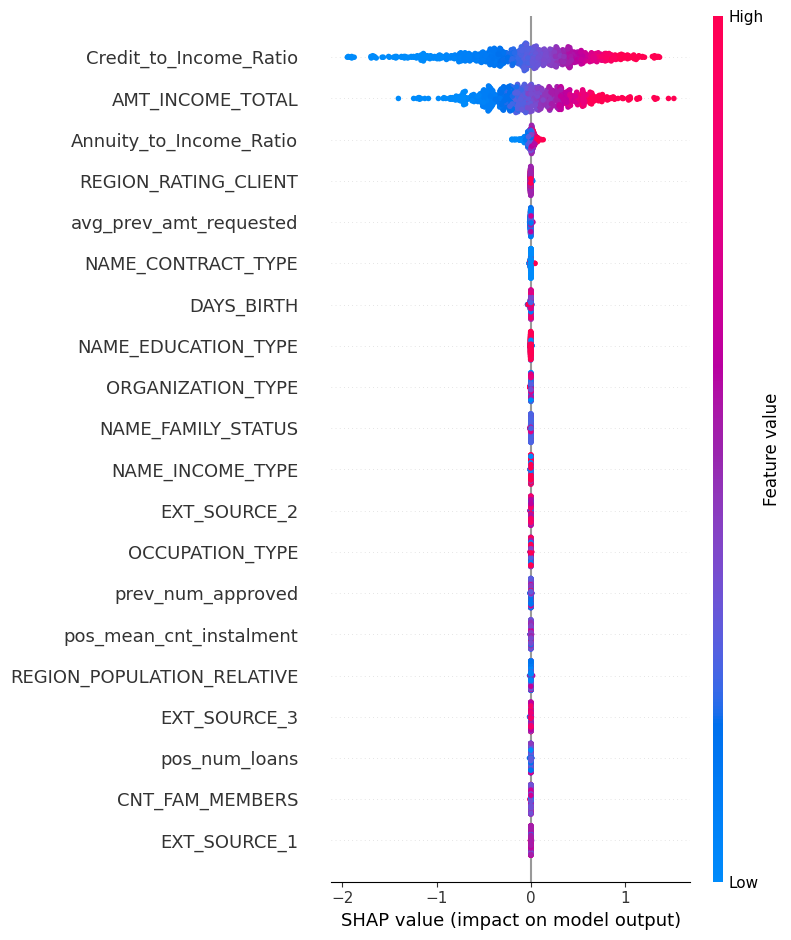

In [17]:
X_shap = X_val.sample(1000, random_state=42)
explainer = shap.TreeExplainer(model4)
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap)

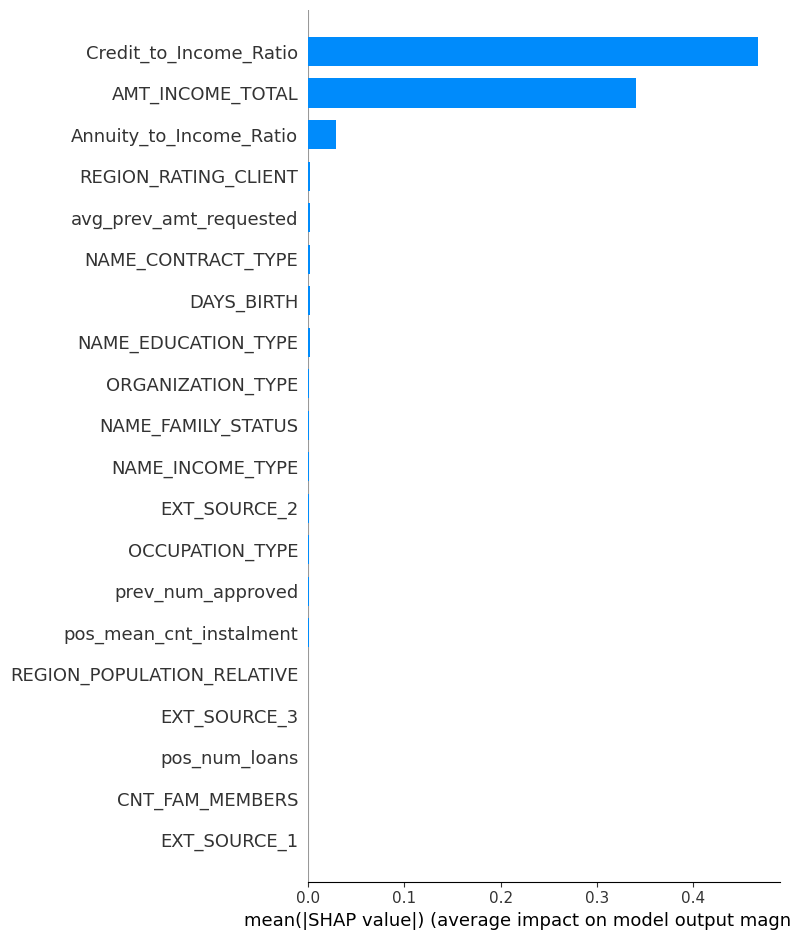

In [18]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

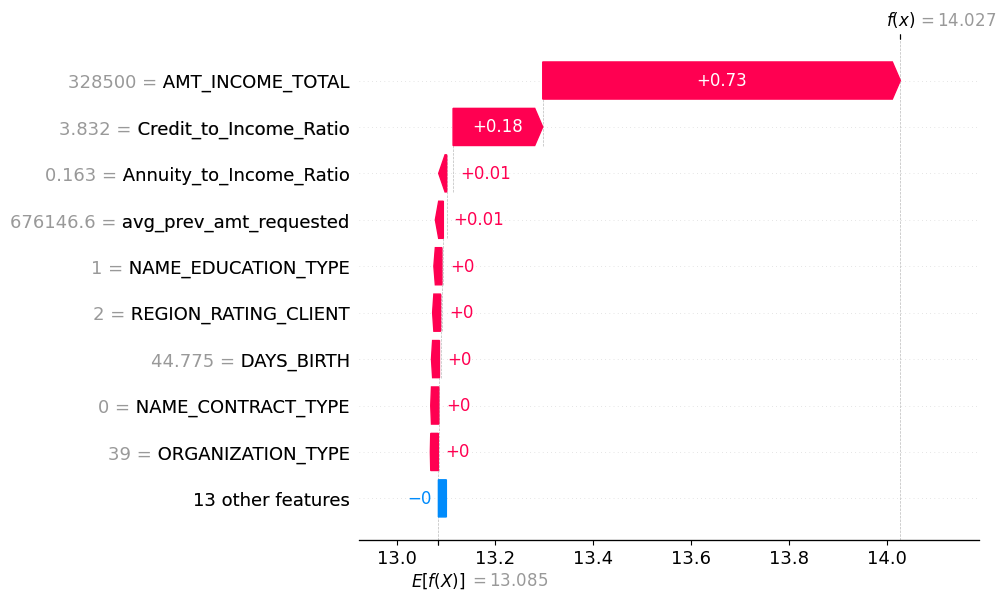

In [22]:
i =901
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=X_shap.iloc[i],
        feature_names=X_shap.columns
    )
)


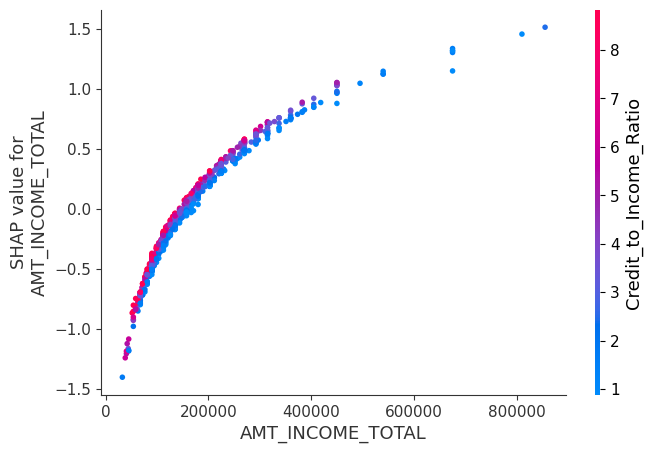

In [23]:
shap.dependence_plot(
    "AMT_INCOME_TOTAL",
    shap_values,
    X_shap
)